# HOMOGRAPHY
### Relation between planar 3D points and image points
<img src="case_1.png">

### Relation between image points of two cameras
$x_1 = H_{21}{\times}x_2$

An image of a planar surface with two AprilTags stuck on it is provided. 

#### Finding homography
The dimensions of each tag and their corner pixel locations are provided in "april\_tags\_info.txt". Using these locations and their corresponding world locations, estimate the $3\times3$ homography matrix, $H$, that maps these world points to their image locations. You can do this by applying the Direct Linear Transform (DLT). 

#### Verification
Verify the accuracy of your estimated $H$ matrix by projecting the physical corner points (in world frame) onto the image plane, and visualize them along with the provided corner pixel locations.

#### Projecting a cube on april tags
Take the dimensions of the 3D cube to be (tag_size, tag_size, 1) in meters. Project two cubes of the given dimensions on the two tags in the given image.

#### Input image
<img src="image.png">

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# Reading the input file.
def read_input_file(filename):
    """
    Reads the input file.
    Input: filename = Name of the text file.
    Output:
        tag_size = Dimension of the tag.
        dist = Distance between the two tags.
        uv_1 = Image points of tag on left. (Upper-left, Upper-right, Lower-right, Lower-left).
        uv_2 = Image points of tag on right. (Upper-left, Upper-right, Lower-right, Lower-left).
    """
    
    f = open(filename,"r")
    f1 = f.readlines()

    tag_size = float(f1[0])
    dist = float(f1[1])
    uv_1 = np.empty([4, 2])
    for i in range(2,6):
        uv_1[i-2, 0] = float(f1[i].split()[0])
        uv_1[i-2, 1]  = float(f1[i].split()[1])
    uv_2 = np.empty([4, 2])
    for i in range(6,10):
        uv_2[i-6, 0] = float(f1[i].split()[0])
        uv_2[i-6, 1]  = float(f1[i].split()[1])

    f.close()
    
    return tag_size, dist, uv_1, uv_2

# Generate 3D points.
def gen_3D_points(side_length, dist):
    """
    Generates 3D points for both the tags where Z is 0. Taking world origin at upper-left corner of left tag.
    Input:
        side_length = Side length of the tag in meters.
        dist = Distance between the two tags in meters.
    Output:
        world_points_left = upper-left, upper-right, lower-right and lower-left positions of left tag.
        world_points_right = upper-left, upper-right, lower-right and lower-left positions of right tag.
    """
    
    world_points_left = np.array([
        [0, 0, 1],
        [side_length, 0, 1],
        [side_length, side_length, 1],
        [0, side_length, 1]
    ])

    world_points_right = np.array([    
        [side_length + dist, 0, 1],
        [2 * side_length + dist, 0, 1],
        [2 * side_length + dist, side_length, 1],
        [side_length + dist, side_length, 1]
    ])
    
    return world_points_left, world_points_right

# Find homography
def compute_homography(uv, XYZ_homo):
    """
    Computes homography matrix.
    Input:
        uv = 2D image points
        XYZ_homo = Corresponding 3D world points where Z is constant.
    Output:
        H = Homography matrix (3 X 3).
    """
    A = np.zeros((2 * uv.shape[0], 9))
    for i in range(uv.shape[0]):
        A[2 * i] = np.hstack((XYZ_homo[i,:], np.zeros((3)), -uv[i, 0] * XYZ_homo[i, :]))
        A[2 * i + 1] = np.hstack((np.zeros((3)), XYZ_homo[i,:], -uv[i, 1] * XYZ_homo[i, :]))
    
    u, s, v = np.linalg.svd(A)
    H = v[-1, :].reshape((3, 3))
    H = H / H[2, 2]
    
    return H

def gen_3D_cubes_points(side_length, dist, z):
    """
    Generates 3D points for the two cubes. Taking world origin at upper-left corner of left tag.
    Input:
        side_length = Side length of the tag in meters.
        dist = Distance between the two tags in meters.
    Output:
        cube_points_left = Vertices of cube on left tag.
        cube_points_right = Vertices of cube on right tag.
    """
    
    cube_points_left = np.array([
        [0, 0, 0, 1],
        [side_length, 0, 0, 1],
        [side_length, side_length, 0, 1],
        [0, side_length, 0, 1],
        [0, 0, z, 1],
        [side_length, 0, z, 1],
        [side_length, side_length, z, 1],
        [0, side_length, z, 1]
    ])

    cube_points_right = np.array([    
        [side_length + dist, 0, 0, 1],
        [2 * side_length + dist, 0, 0, 1],
        [2 * side_length + dist, side_length, 0, 1],
        [side_length + dist, side_length, 0, 1],    
        [side_length + dist, 0, z, 1],
        [2 * side_length + dist, 0, z, 1],
        [2 * side_length + dist, side_length, z, 1],
        [side_length + dist, side_length, z, 1]
    ])
    
    return cube_points_left, cube_points_right    
    

Homography: 
[[ 6.16978679e+02 -3.54442251e+02  2.84580590e+02]
 [-1.81770958e+02  4.22937192e+02  1.49179751e+02]
 [-1.62393574e-01 -1.17639244e+00  1.00000000e+00]]


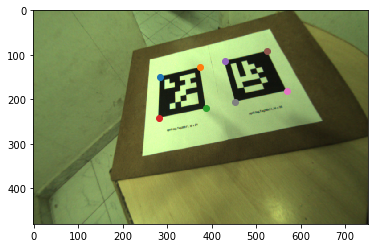

In [3]:
# Read data.
tag_size, dist, uv_left, uv_right = read_input_file("input_file.txt")

# Storing 2D image points and 3D world points.
XYZ_left_homo, XYZ_right_homo = gen_3D_points(tag_size, dist)

# Finding homography.
H = compute_homography(np.vstack((uv_left, uv_right)), np.vstack((XYZ_left_homo, XYZ_right_homo)))
print("Homography: ")
print(H)

# Verification
wrld_pts = np.vstack((XYZ_left_homo, XYZ_right_homo))
tag_img_pts = H @ wrld_pts.T
tag_img_pts = tag_img_pts / tag_img_pts[2, :]
I = plt.imread("image.png")
plt.imshow(I)
for i in range(tag_img_pts.shape[1]):
    plt.scatter(tag_img_pts[0, i], tag_img_pts[1, i])
plt.show()

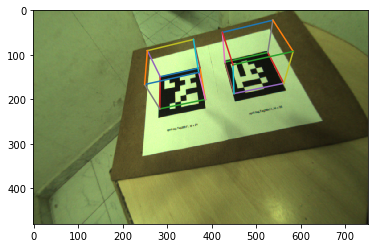

In [4]:
# Given data.
cube_size = np.array([tag_size, tag_size, -0.1])
K = np.array([[406.952636, 0.000000, 366.184147], [0.000000, 405.671292, 244.705127], [0.000000, 0.000000, 1]])

# Decomposing H into R and t
norm_H = np.dot(np.linalg.pinv(K), H)

h1 = norm_H[:,0]; h2 = norm_H[:,1]; h3 = norm_H[:,2]

A = np.zeros((3,3))
A[:,0] = h1; A[:,1] = h2; A[:,2] = np.cross(h1, h2)
(U, S, Vh) = np.linalg.svd(A, full_matrices=True)
S = np.eye(3)
S[2, 2] = np.linalg.det(U @ Vh)
R = U @ S @ Vh
t = h3/np.linalg.norm(h1)
if t[2] < 0:
    t = -t

# 3D vertices of cubes.
cube_left, cube_right = gen_3D_cubes_points(tag_size, dist, cube_size[2])

# Project the cubes on the image.
P = K @ np.hstack((R, np.expand_dims(t, axis=1)))
cubes = np.vstack((cube_left, cube_right))
cubes_img_pts = P @ cubes.T
cubes_img_pts = cubes_img_pts / cubes_img_pts[2, :]
cubes_img_pts = cubes_img_pts.T

I = plt.imread("image.png")
plt.imshow(I)
i = 0
plt.plot(cubes_img_pts[[i+0,i+1], 0], cubes_img_pts[[i+0,i+1], 1])
plt.plot(cubes_img_pts[[i+1,i+2], 0], cubes_img_pts[[i+1,i+2], 1])
plt.plot(cubes_img_pts[[i+2,i+3], 0], cubes_img_pts[[i+2,i+3], 1])
plt.plot(cubes_img_pts[[i+3,i+0], 0], cubes_img_pts[[i+3,i+0], 1])
plt.plot(cubes_img_pts[[i+0,i+4], 0], cubes_img_pts[[i+0,i+4], 1])
plt.plot(cubes_img_pts[[i+1,i+5], 0], cubes_img_pts[[i+1,i+5], 1])
plt.plot(cubes_img_pts[[i+2,i+6], 0], cubes_img_pts[[i+2,i+6], 1])
plt.plot(cubes_img_pts[[i+3,i+7], 0], cubes_img_pts[[i+3,i+7], 1])
plt.plot(cubes_img_pts[[i+4,i+5], 0], cubes_img_pts[[i+4,i+5], 1])
plt.plot(cubes_img_pts[[i+5,i+6], 0], cubes_img_pts[[i+5,i+6], 1])
plt.plot(cubes_img_pts[[i+6,i+7], 0], cubes_img_pts[[i+6,i+7], 1])
plt.plot(cubes_img_pts[[i+7,i+4], 0], cubes_img_pts[[i+7,i+4], 1])

i = 8
plt.plot(cubes_img_pts[[i+0,i+1], 0], cubes_img_pts[[i+0,i+1], 1])
plt.plot(cubes_img_pts[[i+1,i+2], 0], cubes_img_pts[[i+1,i+2], 1])
plt.plot(cubes_img_pts[[i+2,i+3], 0], cubes_img_pts[[i+2,i+3], 1])
plt.plot(cubes_img_pts[[i+3,i+0], 0], cubes_img_pts[[i+3,i+0], 1])
plt.plot(cubes_img_pts[[i+0,i+4], 0], cubes_img_pts[[i+0,i+4], 1])
plt.plot(cubes_img_pts[[i+1,i+5], 0], cubes_img_pts[[i+1,i+5], 1])
plt.plot(cubes_img_pts[[i+2,i+6], 0], cubes_img_pts[[i+2,i+6], 1])
plt.plot(cubes_img_pts[[i+3,i+7], 0], cubes_img_pts[[i+3,i+7], 1])
plt.plot(cubes_img_pts[[i+4,i+5], 0], cubes_img_pts[[i+4,i+5], 1])
plt.plot(cubes_img_pts[[i+5,i+6], 0], cubes_img_pts[[i+5,i+6], 1])
plt.plot(cubes_img_pts[[i+6,i+7], 0], cubes_img_pts[[i+6,i+7], 1])
plt.plot(cubes_img_pts[[i+7,i+4], 0], cubes_img_pts[[i+7,i+4], 1])
plt.show()